In [1]:
from tsai.all import *
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
import pandas as pd
import numpy as np

In [4]:
class EvaluateTsai(object):
  N_EPOCHS=100
  LR=1e-3

  def __init__(self, k, method):
    self.n_folds = k
    self.features = None
    self.labels = None
    self.train_indices = []
    self.test_indices = []
    self.learn = None
    self.dls = None
    self.method = method

  def partition_data(self):

    # Initialize the KFold object
    skf = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=42)

    # Split the data into train and test sets for each fold
    for train_index, test_index in skf.split(self.features, self.labels):
        self.train_indices.append(train_index)
        self.test_indices.append(test_index)

  def train_model(self, X_train,y_train,architecture, alias, parameters, fold):
    # Parameters
    bs=[64, 128]

    # Create time series
    splits=get_splits(y_train,
                      valid_size=.3,
                      stratify=True,
                      random_state=42,
                      shuffle=True
                      )

    tfms=[None,[Categorize()]]
    dsets=TSDatasets(X_train,y_train,tfms=tfms,splits=splits, inplace=True)

    dls=TSDataLoaders.from_dsets(dsets.train,
                                dsets.valid,
                                bs=bs,
                                batch_tfms=[TSStandardize()])
    model = create_model(architecture, dls=dls, **parameters)
    learn = Learner(dls,
                    model,
                    metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(self.N_EPOCHS,
                        lr_max=self.LR)
    print(f'Training model: {alias} for fold: {fold}')
    print('\nElapsed time:', time.time() - start)

    self.learn=learn
    self.dls=dls

  def get_metrics(self, X_test, y_test, architecture, alias, parameters, fold):
    # labelled test data
    test_ds = self.dls.valid.dataset.add_test(X_test, y_test)
    test_dl = self.dls.valid.new(test_ds)

    test_probas, test_targets, test_preds = self.learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)

    accuracy = accuracy_score(test_targets, test_preds)
    precision = precision_score(test_targets, test_preds, average=self.method)
    recall = recall_score(test_targets, test_preds, average=self.method)
    f1 = f1_score(test_targets, test_preds, average=self.method)
    balanced_accuracy = balanced_accuracy_score(test_targets, test_preds)

    iter_dict = {"Accuracy":accuracy,
                 "Precision":precision,
                 "Recall":recall,
                 "F1-Score":f1,
                 "Balanced Accuracy":balanced_accuracy,
                 'Model':alias,
                 'Parameters':parameters,
                 'Iteration':fold}
    return iter_dict

  def evaluate_model(self, architecture, alias, parameters):
    result = list()
    self.partition_data()

    for fold in range(self.n_folds):
        X_train, X_test = self.features[self.train_indices[fold]], self.features[self.test_indices[fold]]
        y_train, y_test = self.labels[self.train_indices[fold]], self.labels[self.test_indices[fold]]

        self.train_model(X_train,y_train,architecture, alias, parameters, fold)
        fold_result = self.get_metrics(X_test, y_test, architecture, alias, parameters,fold)

        result.append(fold_result)

    return pd.DataFrame(result)

In [5]:
def split_data(file):
  SOURCEPATH = '../data'
  data = np.load(f'{SOURCEPATH}/{file}')
  labels = data[:,-3:]
  y = np.argmax(labels, axis=1) + 1
  X = data[:,:-3]
  X = X.reshape(X.shape[0], 1, X.shape[1])
  return X, y

In [6]:
dict_datasets = {
    'dataset_1':{
        'file':'window_4000_overlap_1000_hzdr_norm.npy'
    },
    'dataset_2':{
        'file':'window_4000_overlap_1000_tud_norm.npy'
    }
}

window_4000_overlap_1000_hzdr_norm.npy
dataset_1


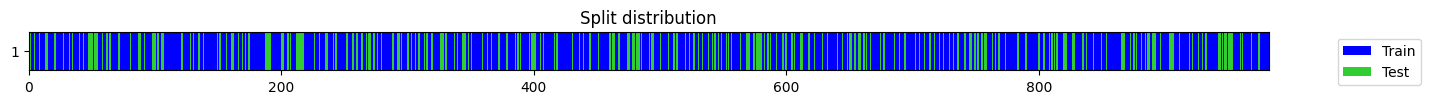

epoch,train_loss,valid_loss,accuracy,time
0,0.908354,1.070068,0.285714,00:04
1,0.767831,0.942437,0.670068,00:00
2,0.665360,0.617445,0.877551,00:00
3,0.581284,0.384948,0.921769,00:00
4,0.519131,0.300092,0.928571,00:00
5,0.463986,0.268289,0.908163,00:00
6,0.417167,0.223275,0.911565,00:00
7,0.380171,0.207924,0.911565,00:00
8,0.348617,0.211120,0.918367,00:00
9,0.319675,0.212400,0.911565,00:00


Training model: ResNet for fold: 0

Elapsed time: 103.61497712135315


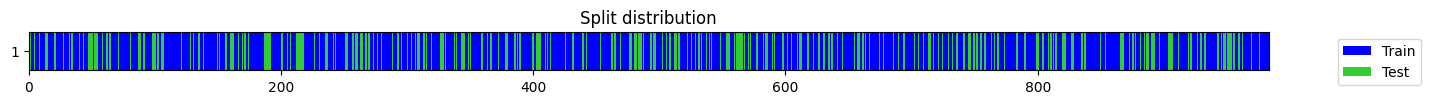

epoch,train_loss,valid_loss,accuracy,time
0,1.010182,1.052199,0.323129,00:00
1,0.857151,0.923975,0.612245,00:00
2,0.741166,0.665229,0.870748,00:00
3,0.642595,0.450158,0.921769,00:03
4,0.562807,0.340877,0.921769,00:00
5,0.496903,0.281439,0.928571,00:00
6,0.443815,0.240220,0.935374,00:00
7,0.398492,0.231390,0.921769,00:00
8,0.358774,0.198026,0.962585,00:00
9,0.324267,0.192358,0.938776,00:00


Training model: ResNet for fold: 1

Elapsed time: 102.62686944007874


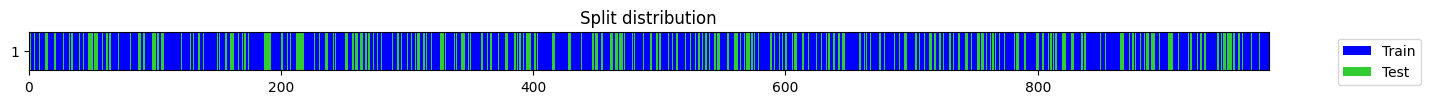

epoch,train_loss,valid_loss,accuracy,time
0,0.833580,1.035961,0.663265,00:00
1,0.711153,0.876514,0.829932,00:00
2,0.619352,0.586640,0.874150,00:00
3,0.542225,0.388667,0.894558,00:00
4,0.481393,0.311315,0.911565,00:00
5,0.430876,0.267201,0.894558,00:00
6,0.387205,0.229068,0.925170,00:04
7,0.351311,0.262599,0.904762,00:00
8,0.319516,0.333534,0.840136,00:00
9,0.293005,0.319826,0.846939,00:00


Training model: ResNet for fold: 2

Elapsed time: 102.35770034790039


Model: ResNet, Parameters: {}, File: ../metrics/dataset_1_ResNet_3-Fold_weighted.csv


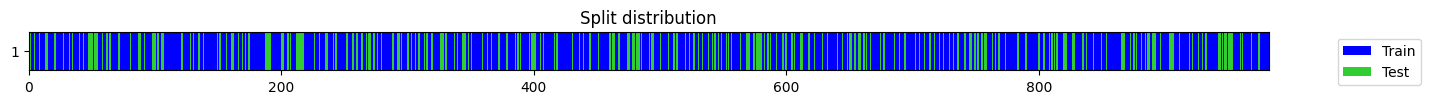

epoch,train_loss,valid_loss,accuracy,time
0,0.972589,0.903880,0.680272,00:00
1,0.873293,0.772380,0.785714,00:00
2,0.795512,0.628693,0.836735,00:00
3,0.720804,0.526400,0.880952,00:00
4,0.658359,0.464058,0.897959,00:00
5,0.603772,0.416991,0.904762,00:00
6,0.553613,0.374534,0.921769,00:00
7,0.506376,0.340508,0.918367,00:00
8,0.462979,0.304897,0.925170,00:00
9,0.424590,0.276222,0.931973,00:00


Training model: LSTM-FCN for fold: 0

Elapsed time: 53.18910074234009


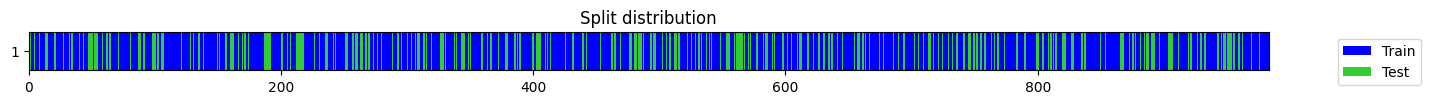

epoch,train_loss,valid_loss,accuracy,time
0,1.037444,0.991742,0.629252,00:00
1,0.924962,0.801365,0.846939,00:00
2,0.829606,0.639440,0.901361,00:00
3,0.750368,0.532586,0.901361,00:00
4,0.681301,0.463936,0.894558,00:00
5,0.619977,0.413923,0.904762,00:00
6,0.565952,0.369587,0.911565,00:00
7,0.517288,0.330599,0.925170,00:00
8,0.472524,0.307068,0.918367,00:00
9,0.432759,0.275488,0.938776,00:00


Training model: LSTM-FCN for fold: 1

Elapsed time: 49.57379221916199


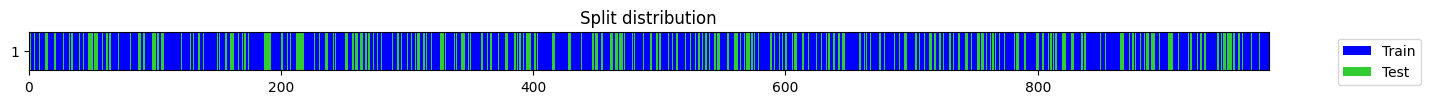

epoch,train_loss,valid_loss,accuracy,time
0,0.939467,0.846213,0.731293,00:00
1,0.835086,0.692059,0.843537,00:00
2,0.746730,0.574152,0.850340,00:00
3,0.675721,0.489566,0.880952,00:00
4,0.614093,0.422246,0.897959,00:00
5,0.559303,0.373520,0.908163,00:00
6,0.513669,0.335777,0.925170,00:00
7,0.469631,0.302589,0.935374,00:00
8,0.428438,0.283753,0.952381,00:00
9,0.394053,0.249750,0.948980,00:00


Training model: LSTM-FCN for fold: 2

Elapsed time: 49.4696147441864


Model: LSTM-FCN, Parameters: {}, File: ../metrics/dataset_1_LSTM-FCN_3-Fold_weighted.csv


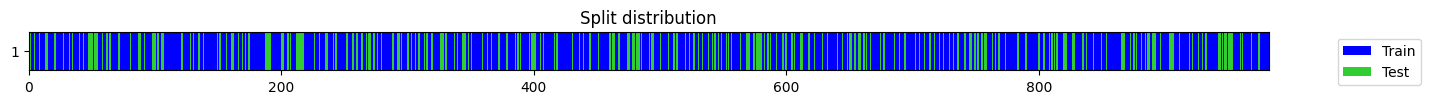

epoch,train_loss,valid_loss,accuracy,time
0,0.497846,0.462998,0.823129,00:15
1,0.345673,0.302089,0.894558,00:08
2,0.282001,0.190824,0.911565,00:07
3,0.237956,0.168020,0.925170,00:11
4,0.208616,0.173814,0.921769,00:07
5,0.181351,0.182543,0.921769,00:07
6,0.162047,0.260956,0.908163,00:08
7,0.142228,0.276479,0.914966,00:11
8,0.130123,0.262002,0.918367,00:07
9,0.116050,0.239967,0.911565,00:07


Training model: TSTPlus for fold: 0

Elapsed time: 899.2737555503845


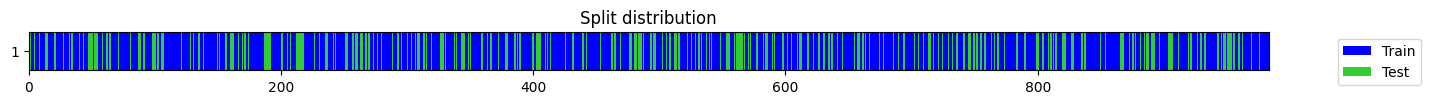

epoch,train_loss,valid_loss,accuracy,time
0,0.567813,0.478641,0.812925,00:11
1,0.403850,0.358404,0.843537,00:07
2,0.330412,0.220302,0.935374,00:10
3,0.292191,0.279918,0.891156,00:08
4,0.259519,0.190588,0.921769,00:12
5,0.231401,0.206388,0.921769,00:08
6,0.203785,0.260871,0.914966,00:07
7,0.180941,0.322365,0.908163,00:08
8,0.164942,0.277197,0.914966,00:11
9,0.150025,0.461208,0.894558,00:06


Training model: TSTPlus for fold: 1

Elapsed time: 919.2284660339355


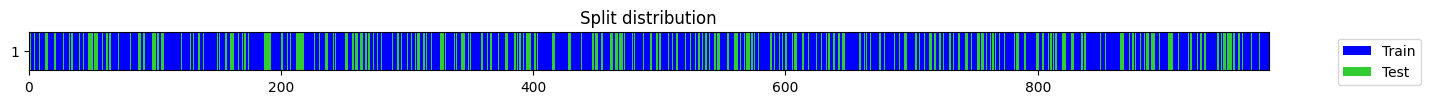

epoch,train_loss,valid_loss,accuracy,time
0,0.604442,0.491301,0.782313,00:08
1,0.432029,0.386586,0.812925,00:11
2,0.342617,0.243803,0.897959,00:07
3,0.285753,0.229925,0.894558,00:07
4,0.241564,0.176426,0.914966,00:07
5,0.217396,0.176948,0.918367,00:11
6,0.195819,0.259863,0.901361,00:09
7,0.177521,0.191705,0.925170,00:08
8,0.157615,0.234200,0.908163,00:08
9,0.141403,0.230688,0.921769,00:11


Training model: TSTPlus for fold: 2

Elapsed time: 895.0831677913666


Model: TSTPlus, Parameters: {}, File: ../metrics/dataset_1_TSTPlus_3-Fold_weighted.csv
window_4000_overlap_1000_tud_norm.npy
dataset_2


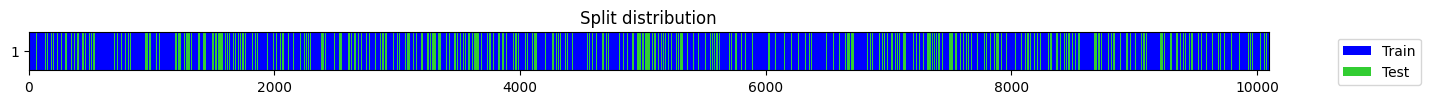

In [ ]:
k = 3
method = 'weighted'

for index in dict_datasets:
  print(dict_datasets[index]['file'])
  print(index)
  X, y = split_data(dict_datasets[index]['file'])
  EVAL = EvaluateTsai(k, method)
  EVAL.features = X
  EVAL.labels = y

  archs = [(ResNet, {}, 'ResNet'),
           (LSTM_FCN, {}, 'LSTM-FCN'),
           (TSTPlus, {}, 'TSTPlus')
           ]

  for (architecture, parameters, alias) in archs:
    df = EVAL.evaluate_model(architecture, alias, parameters)
    FILEPATH = f'../metrics/{index}_{alias}_{k}-Fold_{method}.csv'
    df.to_csv(FILEPATH, index=False)
    print(f'Model: {alias}, Parameters: {parameters}, File: {FILEPATH}')
